In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW, AutoModel, AutoTokenizer, PhobertTokenizer
import warnings
from tqdm import tqdm, trange
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

tokenizer = PhobertTokenizer.from_pretrained("vinai/phobert-base")

cuda


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
train_data = pd.read_csv('Train.csv')
val_data = pd.read_csv('Dev.csv')
test_data = pd.read_csv('Test.csv')

# Convert 5 labels to 3 labels (Negative, Neutral, Positive)
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
      return 0
    elif rating == 3:
      return 1
    else:
      return 2

train_data.n_star = train_data.n_star.apply(to_sentiment)
val_data.n_star = val_data.n_star.apply(to_sentiment)
test_data.n_star = test_data.n_star.apply(to_sentiment)

In [5]:
#To using tokenizer to find max_len (percentile=95)

sequence_lengths = [len(tokenizer.encode(text)) for text in train_data.comment]

max_length = int(np.percentile(sequence_lengths, 95))
max_length

Token indices sequence length is longer than the specified maximum sequence length for this model (277 > 256). Running this sequence through the model will result in indexing errors


100

In [6]:
# Define your labeled dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=100,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

In [7]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [8]:
# Prepare and preprocess your dataset
train_dataset = SentimentDataset(train_data.comment, train_data.n_star, tokenizer)
val_dataset = SentimentDataset(val_data.comment, val_data.n_star, tokenizer)
test_dataset = SentimentDataset(test_data.comment, test_data.n_star, tokenizer)


# Define model and optimizer
model = SentimentClassifier(n_classes=3)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best_val_loss = float('inf')
    batches_per_epoch = len(train_loader)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [],'val_acc': []}

    for epoch in range(num_epochs):
        with trange(batches_per_epoch, unit='batch') as pbar:
            pbar.set_description(f'{epoch + 1} epoch(s)')

            # Training
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            for batch in train_loader:
              input_ids = batch['input_ids'].to(device)
              attention_mask = batch['attention_mask'].to(device)
              labels = batch['label'].to(device)

              optimizer.zero_grad()

              outputs = model(input_ids, attention_mask)
              loss = criterion(outputs, labels)
              _, yhat = torch.max(outputs, dim=1)

              loss.backward()
              optimizer.step()

              train_loss += loss.item()
              train_acc += (yhat == labels).sum().item()
              pbar.update()

            train_loss = round(train_loss,3)
            train_acc = round(train_acc / len(train_data), 3)
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)

            avg_train_loss = train_loss / len(train_loader)

            # Validation
            model.eval()
            val_loss = 0.0
            correct_preds = 0
            total_preds = 0
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids, attention_mask)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, predicted = torch.max(outputs, dim=1)
                    correct_preds += (predicted == labels).sum().item()
                    total_preds += labels.size(0)

            val_acc = round(correct_preds / total_preds,3)
            avg_val_loss = val_loss / len(val_loader)
            val_loss = round(val_loss,3)
            history['val_acc'].append(val_acc)
            history['val_loss'].append(val_loss)

            pbar.set_postfix_str(f'train_loss: {train_loss} -train_acc: {train_acc} -val_loss: {val_loss} -val_acc: {val_acc}')

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), "models/best_phoBert-model.pt")

    print("Training finished.")

    return history



In [10]:
num_epochs = 10
history = train(model, criterion, optimizer, train_loader, val_loader, num_epochs)

10 epoch(s): 100%|██████████| 61/61 [02:02<00:00,  2.02s/batch, train_loss: 18.531 -train_acc: 0.883 -val_loss: 5.465 -val_acc: 0.785]

Training finished.


CLASSIFICATION REPORT 

               precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.17      0.50      0.25         2
           2       0.97      0.94      0.95        33

    accuracy                           0.85        48
   macro avg       0.68      0.71      0.66        48
weighted avg       0.92      0.85      0.88        48


--------------------------------------------------------------------------------




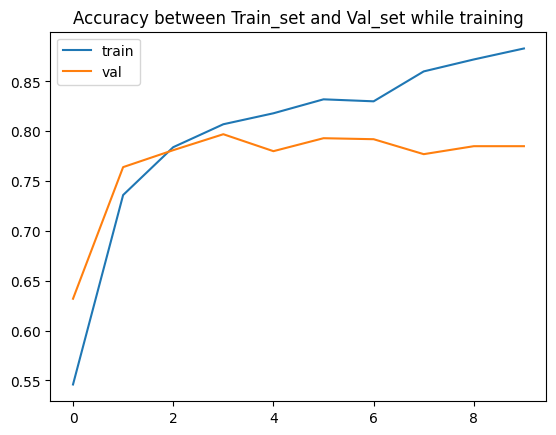

In [11]:
# Evaluation
model.load_state_dict(torch.load("models/best_phoBert-model.pt"))
model.eval()

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, dim=1)

report = classification_report(predicted.cpu().numpy(), labels.cpu().numpy())
print('CLASSIFICATION REPORT \n\n', report)
print()
print('-'*80)
print('\n')
plt.plot(history['train_acc'], label='train')
plt.plot(history['val_acc'], label='val')
plt.title('Accuracy between Train_set and Val_set while training')
plt.legend()
plt.show()